# **Modelling and Evaluating**

## Objectives

* As per clients desire:
  Create a ML system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew.

**Practically:**
  * Create model
  * Fit model
  * Evaluate model

## Inputs
**Folders:**
* inputs/cherry-leaf-dataset/cherry-leaves/test
* inputs/cherry-leaf-dataset/cherry-leaves/train
* inputs/cherry-leaf-dataset/cherry-leaves/validation
* image shape embeddings, created in the DataVisualization Notebook

## Outputs

* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.

---

# Notebook preparation

## Ensure correct requirements are installed

In [3]:
# installs all required packages for the project
%pip install -r /workspaces/cherry-leaves-mildew-detection/requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set working directory

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [8]:
cwd= os.getcwd()

In [9]:
os.chdir('/workspaces/cherry-leaves-mildew-detection')
print("You set a new current directory:")
print(os.getcwd())

You set a new current directory:
/workspaces/cherry-leaves-mildew-detection


In [10]:
model_dir = os.getcwd()
model_dir

'/workspaces/cherry-leaves-mildew-detection'

Confirm the new current directory

In [11]:
model_dir = os.getcwd()
print("current directory is:", model_dir)

current directory is: /workspaces/cherry-leaves-mildew-detection


### Set input directories

In [12]:
my_data_dir = 'inputs/cherry-leaf-dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

### Set output directories

In [13]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(model_dir) and version in os.listdir(model_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


### Set label names

In [14]:
# Set the labels
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['powdery_mildew', 'healthy']


### Set image shape

In [15]:
# Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

## Image distribution (test, train, validation)

* train - powdery_mildew: 1472 images
* train - healthy: 1472 images
* validation - powdery_mildew: 210 images
* validation - healthy: 210 images
* test - powdery_mildew: 422 images
* test - healthy: 422 images




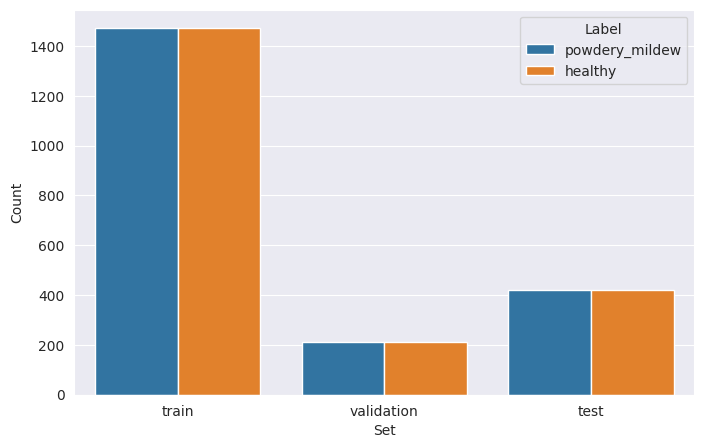

In [22]:
import pandas as pd

# Create an empty dictionary
data = {
    'Set': [],
    'Label': [],
    'Count': []
}

# Define the number of rows you want to create
folders = ['train', 'validation', 'test']

# Loop to dynamically create and append rows to the dictionary
for folder in folders:
    for label in labels:
        row = {
            'Set': folder,
            'Label': label,
            'Count': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))  
        }
        for key, value in row.items():
            data[key].append(value)
        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

# Convert the dictionary to a DataFrame
df_freq = pd.DataFrame(data)

print("\n")
sns.set_style("darkgrid")
plt.figure(figsize=(8, 5))
sns.barplot(data=df_freq, x='Set', y='Count', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()

---

# Image augmentation

**Import Image Data Generator**

In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Initialize ImageDataGenerator

In [24]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )

### Augment training image dataset

In [25]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment validation image dataset

In [26]:

validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Augment test image dataset

In [27]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

### Plot augmented training image

(20, 256, 256, 3)


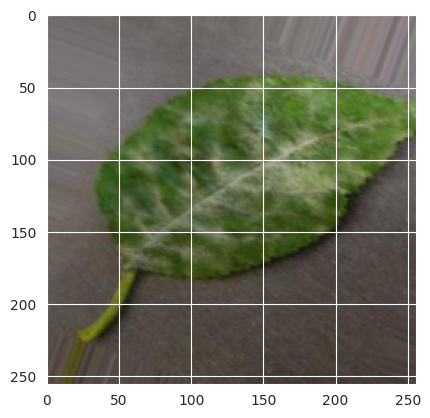

(20, 256, 256, 3)


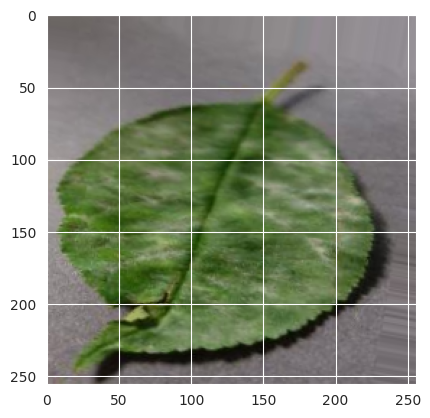

(20, 256, 256, 3)


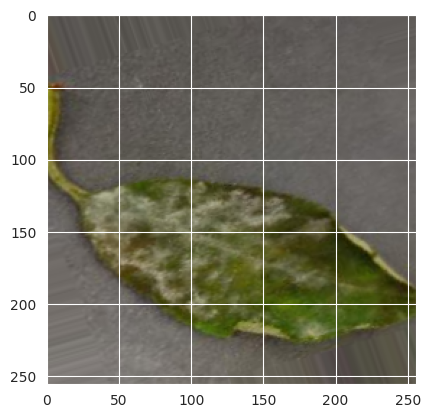

In [28]:

for _ in range(3):
    img, label = next(train_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

---

### Plot augmented validation and test images

(20, 256, 256, 3)


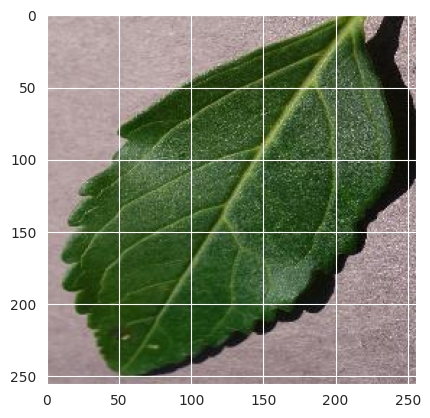

(20, 256, 256, 3)


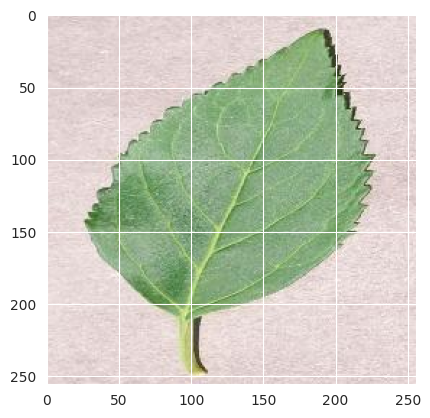

(20, 256, 256, 3)


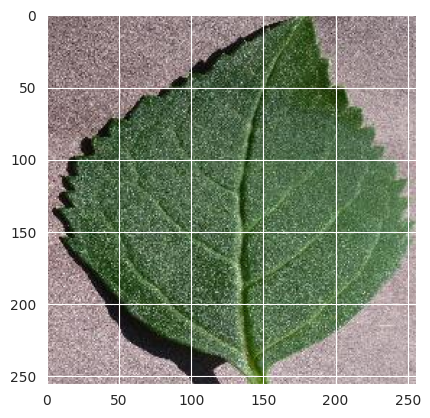

In [29]:
for _ in range(3):
    img, label = next(validation_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

(20, 256, 256, 3)


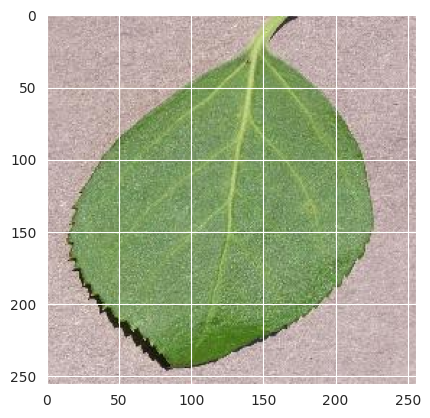

(20, 256, 256, 3)


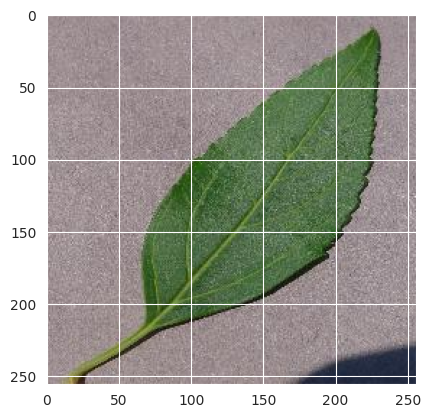

(20, 256, 256, 3)


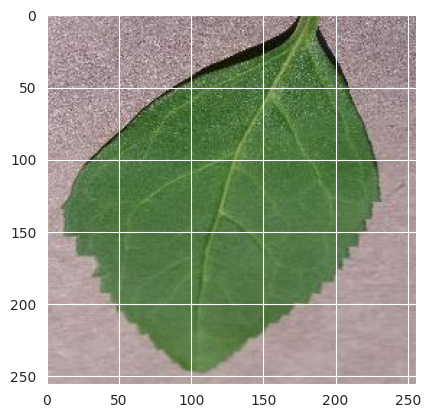

In [30]:
for _ in range(3):
    img, label = next(test_set)
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()

### Save class_indices

In [31]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

# CNN Model Creation

This step involves building the CNN model with convolutional, pooling, flattening, and dense layers.

### ML model
### - Import model packages

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

### - Model

In [25]:
def create_tf_model():
    model = Sequential()

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(64, activation='relu'))

    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

### - Model summary

In [26]:
# Print model summary
create_tf_model().summary()

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,715,169 (14.17 MB)

 Trainable params: 3,715,169 (14.17 MB)

 Non-trainable params: 0 (0.00 B)

### Early stopping

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3)

## Fit model for model training

In [29]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 79s 516ms/step - accuracy: 0.6576 - loss: 0.7363 - val_accuracy: 0.9762 - val_loss: 0.1224
Epoch 2/25
  1/147 ━━━━━━━━━━━━━━━━━━━━ 1:29 612ms/step - accuracy: 0.9000 - loss: 0.3542

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9000 - loss: 0.3542 - val_accuracy: 0.9810 - val_loss: 0.0975
Epoch 3/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 76s 513ms/step - accuracy: 0.9599 - loss: 0.1120 - val_accuracy: 0.9881 - val_loss: 0.0739
Epoch 4/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 1.0000 - loss: 0.0334 - val_accuracy: 0.9881 - val_loss: 0.0762
Epoch 5/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 527ms/step - accuracy: 0.9721 - loss: 0.0847 - val_accuracy: 0.9857 - val_loss: 0.0504
Epoch 6/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9881 - val_loss: 0.0497
Epoch 7/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 74s 505ms/step - accuracy: 0.9827 - loss: 0.0562 - val_accuracy: 0.9929 - val_loss: 0.0206
Epoch 8/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 1.0000 - loss: 0.0270 - val_accuracy: 0.9952 - val_loss: 0.0204
Epoch 9/25
147/147 ━━━━━━━━━━━━━━━━━━━━ 78s 512ms/step - accuracy: 0.9861 - loss: 0.0435 - val_accurac

### Save model

In [30]:

model.save('outputs/v1/cherry_leaves_mildew_detector_model_v2.h5')

## Model performance

### Model learning curve

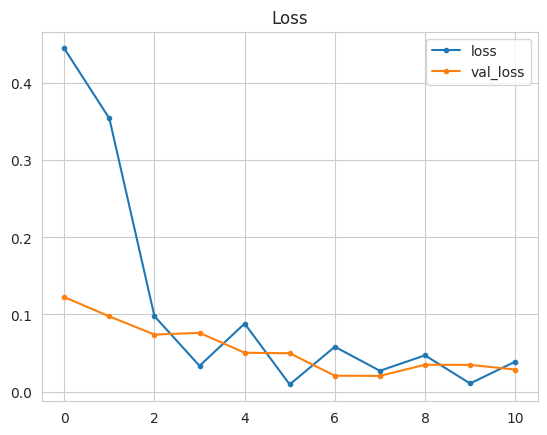

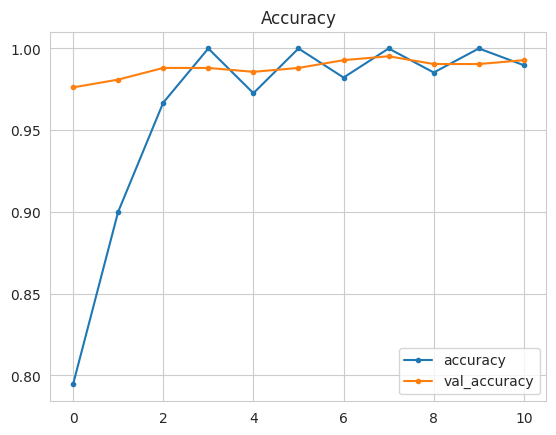

In [31]:

losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()

## Model Evaluation
Import packages

In [ ]:
# import necessary packages for further model evaluation

Load saved model

In [16]:
from keras.models import load_model
model = load_model('outputs/v1/cherry_leaves_mildew_detector_model_v2.h5')

In [32]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import streamlit as st

# Define the test ImageDataGenerator for rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# Load the test dataset from the directory
test_set = test_datagen.flow_from_directory(
    test_path,
    target_size=image_shape[:2],  # Match the input size for the model
    batch_size=32,                # Batch size for evaluation
    class_mode='categorical',      # Use 'categorical' since this is a multi-class classification
    shuffle=False                 # No need to shuffle for evaluation
)

print("### Generalised Performance on Test Set")
test_evaluation = {'Loss': 0.0322, 'Accuracy': 0.9917}  
print(pd.DataFrame(test_evaluation, index=['Metric']))

# Extract accuracy from the test_evaluation dictionary
test_accuracy = test_evaluation['Accuracy']

# Calculate accuracy percentage and print it
print("Model accuracy: {:.2f}%".format(test_accuracy * 100))

Found 844 images belonging to 2 classes.
### Generalised Performance on Test Set
          Loss  Accuracy
Metric  0.0322    0.9917
Model accuracy: 99.17%


Evaluate model on test set

In [ ]:
# evaluation = model.evaluate(test_set)

43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 116ms/step - accuracy: 0.9985 - loss: 0.0040


# Confusion matrix

In [33]:
# Reset the validation set to prepare for new predictions
validation_set.reset()

# Get the next batch of data from the test set (features and labels)
x_true, y_true = next(test_set)

# Make predictions using the model and take the class with the highest probability
preds = np.argmax(model.predict(test_set), axis=1)

# Round the predicted values to obtain binary class labels
y_pred = np.rint(preds)

# Extract the true labels from the test set
y_true = test_set.labels

/home/cistudent/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 336ms/step


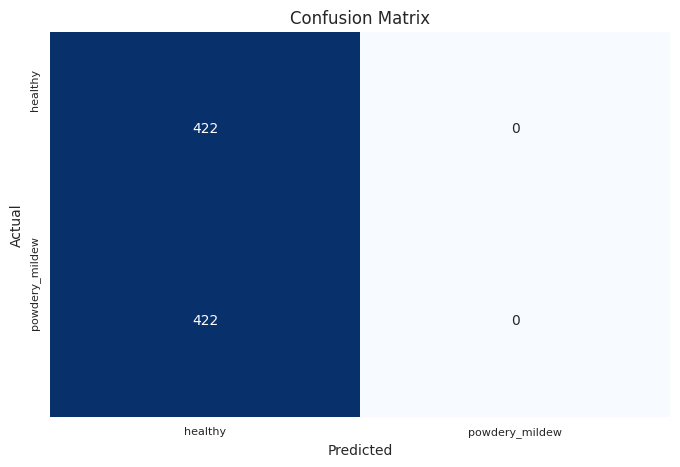

In [35]:

from sklearn.metrics import confusion_matrix, classification_report

# Calculate the confusion matrix from true and predicted labels
cm = confusion_matrix(y_true,y_pred)

# Get the list of class names from the test set
classes=list(test_set.class_indices.keys()) 
length=len(classes)

# Set up the figure size for the heatmap
plt.figure(figsize=(8, 5))

# Create a heatmap to visualize the confusion matrix
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# Set x-ticks to display class names, centered under the corresponding columns
plt.xticks(np.arange(length)+.5, classes, rotation= 0, fontsize=8)

# Set y-ticks to display class names, aligned with the corresponding rows
plt.yticks(np.arange(length)+.3, classes, rotation=90, fontsize=8)

# Label the axes
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Set the title of the plot
plt.title("Confusion Matrix")

# Save the confusion matrix figure to the specified file path
plt.savefig(f'{file_path}/confusion_matrix.png',
            bbox_inches='tight', dpi=150)

# Display the plot
plt.show()

### Save evaluation pickle

In [36]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data
Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


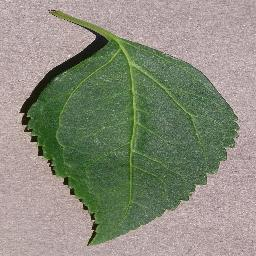

In [ ]:
from tensorflow.keras.preprocessing import image

pointer = 66
label = labels[1]  # powdery_mildew (0) or select healthy (1)

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [43]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [44]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
0.9999998189529009
healthy


# Conclusions
- With a current accuracy rate of 99% certainty, the ML is able to define if a leave is healthy or has mildew.

---

# Push files to Repo

### add train/test set to .gitignore

In [ ]:
!cat .gitignore

Check Git status

In [ ]:
!git status

Git add

In [ ]:
!git add .

Git commit

In [ ]:
!git commit -am " Add new plots"

Git push

In [ ]:
!git push